<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  569 non-null    int64  
 1   Diagnosis           569 non-null    object 
 2   radius1             569 non-null    float64
 3   texture1            569 non-null    float64
 4   perimeter1          569 non-null    float64
 5   area1               569 non-null    float64
 6   smoothness1         569 non-null    float64
 7   compactness1        569 non-null    float64
 8   concavity1          569 non-null    float64
 9   concave_points1     569 non-null    float64
 10  symmetry1           569 non-null    float64
 11  fractal_dimension1  569 non-null    float64
 12  radius2             569 non-null    float64
 13  texture2            569 non-null    float64
 14  perimeter2          569 non-null    float64
 15  area2               569 non-null    float64
 16  smoothne

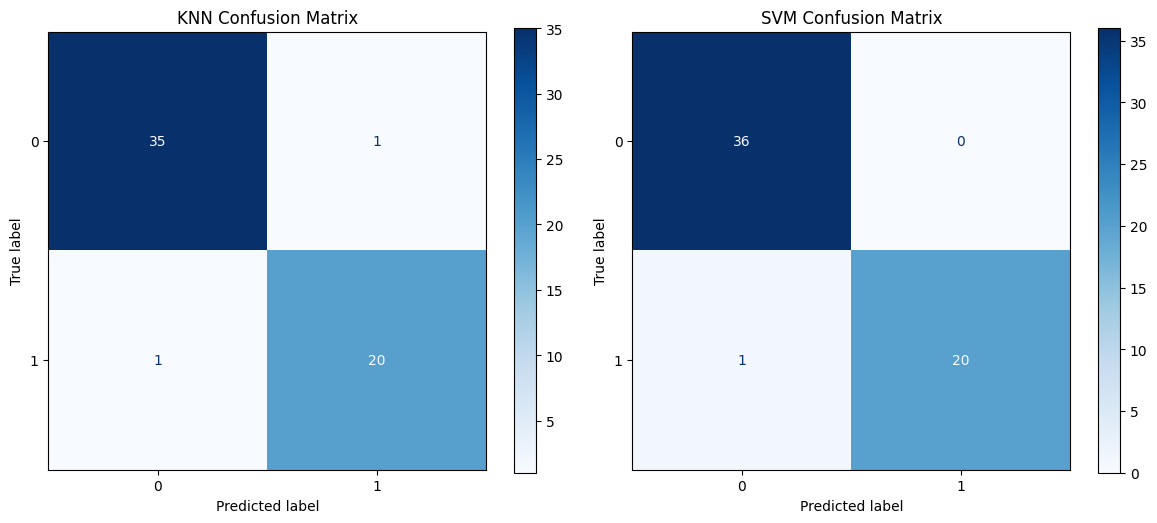

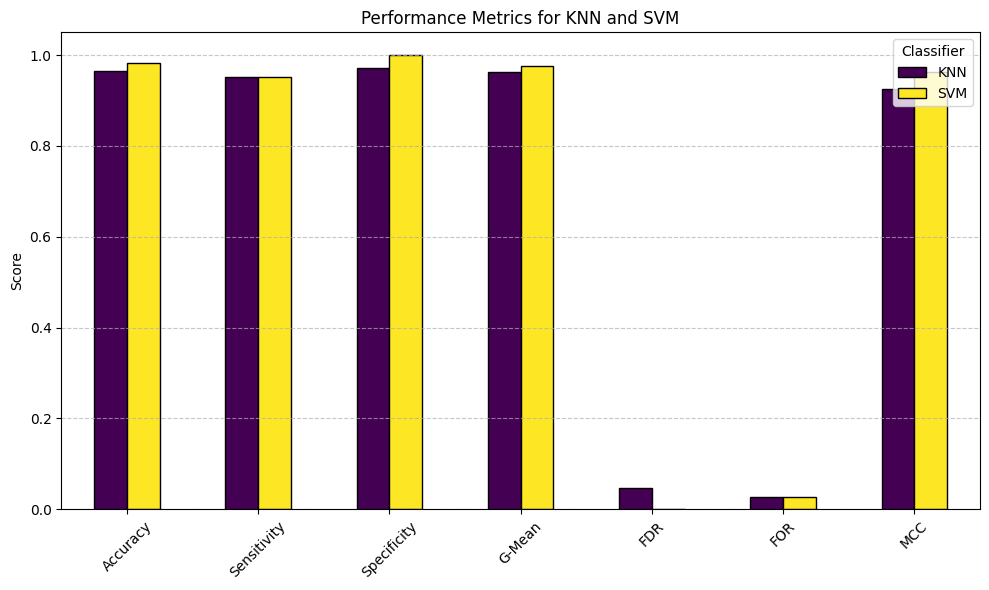

In [1]:
# Task 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

columns = [
    "ID", "Diagnosis", "radius1", "texture1", "perimeter1", "area1", "smoothness1", "compactness1", 
    "concavity1", "concave_points1", "symmetry1", "fractal_dimension1", "radius2", "texture2", 
    "perimeter2", "area2", "smoothness2", "compactness2", "concavity2", "concave_points2", 
    "symmetry2", "fractal_dimension2", "radius3", "texture3", "perimeter3", "area3", 
    "smoothness3", "compactness3", "concavity3", "concave_points3", "symmetry3", 
    "fractal_dimension3"
]

data = pd.read_csv('wdbc.data', header=None, names=columns)

data.shape
data.info()
data.head()


missing_values = data.isnull().sum()

data['Diagnosis'] = LabelEncoder().fit_transform(data['Diagnosis'])

data = data.drop(columns=['ID'])

X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape, y.shape



X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='rbf', probability=True, random_state=42)
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)

def calculate_metrics(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    gmean = (sensitivity * specificity) ** 0.5
    fdr = fp / (fp + tp) 
    forate = fn / (fn + tn) 
    mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    return {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'G-Mean': gmean,
        'FDR': fdr,
        'FOR': forate,
        'MCC': mcc
    }



metrics_knn = calculate_metrics(y_test, y_pred_knn)
metrics_svm = calculate_metrics(y_test, y_pred_svm)


metrics_results = pd.DataFrame([metrics_knn, metrics_svm], index=['KNN', 'SVM']).T

print("Metrics Results:")
print(metrics_results)



fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot(cmap=plt.cm.Blues, ax=axes[0], values_format='d')
axes[0].set_title('KNN Confusion Matrix')


cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap=plt.cm.Blues, ax=axes[1], values_format='d')
axes[1].set_title('SVM Confusion Matrix')

plt.tight_layout()
plt.show()

metrics_results.plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Performance Metrics for KNN and SVM')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Classifier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
# Task 2


import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder


columns = [
    "ID", "Diagnosis", "radius1", "texture1", "perimeter1", "area1", "smoothness1", "compactness1", 
    "concavity1", "concave_points1", "symmetry1", "fractal_dimension1", "radius2", "texture2", 
    "perimeter2", "area2", "smoothness2", "compactness2", "concavity2", "concave_points2", 
    "symmetry2", "fractal_dimension2", "radius3", "texture3", "perimeter3", "area3", 
    "smoothness3", "compactness3", "concavity3", "concave_points3", "symmetry3", 
    "fractal_dimension3"
]

data = pd.read_csv('wdbc.data', header=None, names=columns)



data['Diagnosis'] = LabelEncoder().fit_transform(data['Diagnosis'])
data = data.drop(columns=['ID']) 

X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def calculate_f_scores(X, y):
    f_scores = []
    
    for i in range(X.shape[1]):
        feature = X[:, i]
        mean_pos = np.mean(feature[y == 1])
        mean_neg = np.mean(feature[y == 0])
        mean_total = np.mean(feature)
        numerator = (mean_pos - mean_total) ** 2 + (mean_neg - mean_total) ** 2
        denom_pos = np.var(feature[y == 1])
        denom_neg = np.var(feature[y == 0])
        denominator = (1 / len(feature[y == 1]) * denom_pos) + (1 / len(feature[y == 0]) * denom_neg)
        f_scores.append(numerator / denominator)
        
    return np.array(f_scores)

f_scores = calculate_f_scores(X_scaled, y)
features_sorted = np.argsort(f_scores)[::-1]

feature_subsets = [features_sorted[:i] for i in range(1, 10)]


def evaluate_svm(X_train, X_test, y_train, y_test, features):
    X_train_sub = X_train[:, features]
    X_test_sub = X_test[:, features]
    
    model = SVC(kernel='rbf', C=1, gamma=0.1) 
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)
    
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) 
    
    return accuracy, sensitivity, specificity, cm


def evaluate(X, y, splits, feature_subsets):
    results = []
    for split_name, test_size in splits.items():
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

        for i, features in enumerate(feature_subsets):
            accuracy, sensitivity, specificity, cm = evaluate_svm(X_train, X_test, y_train, y_test, features)
            results.append({
                'Split': split_name,
                'Model': f"Model #{i+1}",
                'Features': len(features),
                'Accuracy': accuracy,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Confusion Matrix': cm
            })
    return results


splits = {'50-50': 0.5, '70-30': 0.3, '80-20': 0.2}

results = evaluate(X_scaled, y, splits, feature_subsets)

results_df = pd.DataFrame(results)


table_4 = results_df.pivot_table(index=['Model'], columns='Split', values='Accuracy', aggfunc='mean')
print("\nTable 4:")
print(table_4)

model_5_results = results_df[results_df['Model'] == 'Model #5']

print("\nTable 6 and 7:")
for idx, res in model_5_results.iterrows():
    print(f"\n{res['Split']}:")
    print(f"Sensitivity: {res['Sensitivity']}, Specificity: {res['Specificity']}")
    print(f"Confusion Matrix:\n{res['Confusion Matrix']}")




Table 4:
Split        50-50     70-30     80-20
Model                                 
Model #1  0.919298  0.935673  0.929825
Model #2  0.954386  0.953216  0.956140
Model #3  0.943860  0.953216  0.938596
Model #4  0.943860  0.947368  0.947368
Model #5  0.947368  0.947368  0.956140
Model #6  0.947368  0.947368  0.947368
Model #7  0.940351  0.941520  0.947368
Model #8  0.943860  0.941520  0.938596
Model #9  0.943860  0.941520  0.938596

Table 6 and 7:

50-50:
Sensitivity: 0.8867924528301887, Specificity: 0.9832402234636871
Confusion Matrix:
[[176   3]
 [ 12  94]]

70-30:
Sensitivity: 0.875, Specificity: 0.9906542056074766
Confusion Matrix:
[[106   1]
 [  8  56]]

80-20:
Sensitivity: 0.9047619047619048, Specificity: 0.9861111111111112
Confusion Matrix:
[[71  1]
 [ 4 38]]


In [3]:
# Task 3
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

columns = [
    "ID", "Diagnosis", "radius1", "texture1", "perimeter1", "area1", "smoothness1", "compactness1", 
    "concavity1", "concave_points1", "symmetry1", "fractal_dimension1", "radius2", "texture2", 
    "perimeter2", "area2", "smoothness2", "compactness2", "concavity2", "concave_points2", 
    "symmetry2", "fractal_dimension2", "radius3", "texture3", "perimeter3", "area3", 
    "smoothness3", "compactness3", "concavity3", "concave_points3", "symmetry3", 
    "fractal_dimension3"
]

data = pd.read_csv('wdbc.data', header=None, names=columns)



data['Diagnosis'] = LabelEncoder().fit_transform(data['Diagnosis'])

data = data.drop(columns=['ID'])

if data.isnull().sum().sum() > 0:
    print("Missing values detected!")
else:
    print("No missing values detected.")

X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)




def svm_default(X_train, X_test, y_train, y_test, kernels):
    results = {}
    for kernel in kernels:
        print(f"\nSVM with {kernel} kernel:")
        
        model = SVC(kernel=kernel, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        results[kernel] = {
            'accuracy': accuracy,
            'report': classification_report(y_test, y_pred)
        }
        print(f"Accuracy with {kernel} kernel: {accuracy:.4f}")
    return results

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

print("\nSVM with default parameters:")
default_results = svm_default(X_train, X_test, y_train, y_test, kernels)



print("\nGrid Search with tuned parameters:")
tuned_results = {}
param_grid = {
    'linear': {'C': [0.1, 1, 10, 100]},
    'poly': {'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
    'rbf': {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]},
    'sigmoid': {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]}
}

for kernel in kernels:
    print(f"\nGrid Search for {kernel} kernel:")
    
    grid = GridSearchCV(SVC(kernel=kernel, random_state=42), param_grid[kernel], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    tuned_results[kernel] = {
        'best_params': grid.best_params_,
        'accuracy': accuracy,
        'report': classification_report(y_test, y_pred)
    }
    print(f"Best parameters for {kernel} kernel: {grid.best_params_}")
    print(f"Accuracy with {kernel} kernel (tuned): {accuracy:.4f}")



print("\nComparing Default Parameter Results and Tuned Results:")

for kernel in kernels:
    print(f"\n{kernel} Kernal:")
    print(f"Default Accuracy: {default_results[kernel]['accuracy']:.4f}")
    print(f"Tuned Accuracy: {tuned_results[kernel]['accuracy']:.4f}")

No missing values detected.

SVM with default parameters:

SVM with linear kernel:
Accuracy with linear kernel: 0.9649

SVM with poly kernel:
Accuracy with poly kernel: 0.8860

SVM with rbf kernel:
Accuracy with rbf kernel: 0.9737

SVM with sigmoid kernel:
Accuracy with sigmoid kernel: 0.9474

Grid Search with tuned parameters:

Grid Search for linear kernel:
Best parameters for linear kernel: {'C': 0.1}
Accuracy with linear kernel (tuned): 0.9825

Grid Search for poly kernel:
Best parameters for poly kernel: {'C': 10, 'degree': 3}
Accuracy with poly kernel (tuned): 0.9386

Grid Search for rbf kernel:
Best parameters for rbf kernel: {'C': 100, 'gamma': 0.01}
Accuracy with rbf kernel (tuned): 0.9561

Grid Search for sigmoid kernel:
Best parameters for sigmoid kernel: {'C': 1, 'gamma': 0.01}
Accuracy with sigmoid kernel (tuned): 0.9561

Comparing Default Parameter Results and Tuned Results:

linear Kernal:
Default Accuracy: 0.9649
Tuned Accuracy: 0.9825

poly Kernal:
Default Accuracy: 0.